In [1]:
import pystac_client
import planetary_computer as pc

import rasterio
import rioxarray as rioxr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import shapely
import os

from shapely.geometry import shape

In [2]:
YEAR = 2018

## Access NAIP image collection in Planetary Computer
Adapted from sample notebook in Planetary Computer NAIP example code

In [3]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

In [4]:
# Bounding box around Campus Point
# created using https://boundingbox.klokantech.com
area_of_interest = {
    "type": "Polygon",
    "coordinates": [[
        [-119.8610195981,34.3938837903],
        [-119.8306927339,34.3938837903],
        [-119.8306927339,34.420119945],
        [-119.8610195981,34.420119945],
        [-119.8610195981,34.3938837903]
    ]],
}
# Temporal range of interest
date_range = str(YEAR)+'-01-01/'+str(YEAR)+'-12-31'

# look in NAIP catalog for items on specified date and geographic range
search = catalog.search(
    collections=["naip"], 
    intersects=area_of_interest, 
    datetime=date_range
)

items = list(search.get_items())
print(f"{len(items)} Items found in the 'new' range")

1 Items found in the 'new' range


In [5]:
# choose the item that has the most overlap:
area_shape = shape(area_of_interest)
target_area = area_shape.area

def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(area_of_interest)).area
    return overlap_area / target_area

item = sorted(items, key=area_of_overlap, reverse=True)[0]

In [15]:
def print_dict(dictionary):
    for key, value in dictionary.items():
        print(key, ' : ', value)
    print('\n')
    return

print(item, '\n')
print('type:', type(item))
print_dict(item.properties)
print_dict(item.assets)

<Item id=ca_m_3411934_sw_11_060_20180722_20190209> 

gsd  :  0.6
datetime  :  2018-07-22T00:00:00Z
naip:year  :  2018
proj:bbox  :  [235476.0, 3807168.0, 241728.0, 3814572.0]
proj:epsg  :  26911
naip:state  :  ca
proj:shape  :  [12340, 10420]
proj:transform  :  [0.6, 0.0, 235476.0, 0.0, -0.6, 3814572.0, 0.0, 0.0, 1.0]


image  :  <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_060cm_2018/34119/m_3411934_sw_11_060_20180722_20190209.tif>
metadata  :  <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_fgdc_2018/34119/m_3411934_sw_11_060_20180722.txt>
thumbnail  :  <Asset href=https://naipeuwest.blob.core.windows.net/naip/v002/ca/2018/ca_060cm_2018/34119/m_3411934_sw_11_060_20180722_20190209.200.jpg>
tilejson  :  <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=naip&item=ca_m_3411934_sw_11_060_20180722_20190209&assets=image&asset_bidx=image%7C1%2C2%2C3>
rendered_preview  :  <Asset href=https://pla

In [6]:
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
print(type(ds))

<class 'rasterio.io.DatasetReader'>


In [7]:
# Explore opened dataset
print('type: ', type(ds))
print('mode: ', ds.mode)
print('# bands: ', ds.count, '\n')

print('collection date:', item.datetime, '\n')
      
print('height: ',ds.height)
print('width: ', ds.width, '\n')
      
print('CRS: ', ds.crs)      
print('spatial bounding box: ')
print(ds.bounds)
print('affine transform: ')
print(ds.transform)   # see also get_transform() and read_transform()
print('resolution:', ds.res)

type:  <class 'rasterio.io.DatasetReader'>
mode:  r
# bands:  4 

collection date: 2018-07-22 00:00:00+00:00 

height:  12340
width:  10420 

CRS:  EPSG:26911
spatial bounding box: 
BoundingBox(left=235476.0, bottom=3807168.0, right=241728.0, top=3814572.0)
affine transform: 
| 0.60, 0.00, 235476.00|
| 0.00,-0.60, 3814572.00|
| 0.00, 0.00, 1.00|
resolution: (0.6, 0.6)


In [8]:
# check image
# some re-arranging of the order of the bands needs to be doe to fd it into .imshow
#plt.imshow(np.moveaxis(ds.read(indexes=[1,2,3]),0,-1)) 

## Select GBIF year data

In [11]:
# this data was saved to memory from GBIF datset on the Planetary Comp
# see notebook selecting_gbif_data

gbifdata = 'c_edulis_observations.csv'
obs_all = pd.read_csv(os.path.join(os.getcwd(),'aux_data',gbifdata))

obs_all = gpd.GeoDataFrame(
    obs_all,
    crs = "EPSG:4326",
    geometry = gpd.points_from_xy(
        x= obs_all.decimallongitude,
        y= obs_all.decimallatitude)
)


print('# observations:', obs_all.shape[0])
print('# columns:', obs_all.shape[1], '\n')
print(obs_all.columns)
#obs_all.head()

# observations: 427
# columns: 52 

Index(['Unnamed: 0', 'gbifid', 'datasetkey', 'occurrenceid', 'kingdom',
       'phylum', 'class', 'order', 'family', 'genus', 'species',
       'infraspecificepithet', 'taxonrank', 'scientificname',
       'verbatimscientificname', 'verbatimscientificnameauthorship',
       'countrycode', 'locality', 'stateprovince', 'occurrencestatus',
       'individualcount', 'publishingorgkey', 'decimallatitude',
       'decimallongitude', 'coordinateuncertaintyinmeters',
       'coordinateprecision', 'elevation', 'elevationaccuracy', 'depth',
       'depthaccuracy', 'eventdate', 'day', 'month', 'year', 'taxonkey',
       'specieskey', 'basisofrecord', 'institutioncode', 'collectioncode',
       'catalognumber', 'recordnumber', 'identifiedby', 'dateidentified',
       'license', 'rightsholder', 'recordedby', 'typestatus',
       'establishmentmeans', 'lastinterpreted', 'mediatype', 'issue',
       'geometry'],
      dtype='object')


In [12]:
# select data for yeear of interest: YEAR defined at top of notebok

obs = obs_all.loc[obs_all['year'] == YEAR]
obs = obs[['year',
           'month',
           'geometry', 
           'decimallatitude', 'decimallongitude', 
           'coordinateuncertaintyinmeters',
           'institutioncode']]
obs.reset_index(drop=True, inplace=True)
print('# observations:', obs.shape[0])
obs.head()

# observations: 62


,year,month,geometry,decimallatitude,decimallongitude,coordinateuncertaintyinmeters,institutioncode
0,2018.0,4.0,POINT (-122.53049 38.00750),38.007500,-122.530487,5.0,iNaturalist
1,2018.0,12.0,POINT (-121.91021 36.62163),36.621633,-121.910213,NaN,iNaturalist
2,2018.0,4.0,POINT (-122.48073 37.79367),37.793672,-122.480735,14.0,iNaturalist
3,2018.0,6.0,POINT (-120.86054 35.37261),35.372605,-120.860542,5.0,iNaturalist
4,2018.0,2.0,POINT (-122.43967 37.43072),37.430723,-122.439666,4.0,iNaturalist


In [13]:
# Remove those above certain threshold for accuracy?
# keeping all for the time being
np.unique(obs.coordinateuncertaintyinmeters)

array([4.00e+00, 5.00e+00, 6.00e+00, 1.00e+01, 1.20e+01, 1.40e+01,
       1.60e+01, 1.39e+02, 1.86e+02, 2.37e+02, 4.72e+03,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan,
            nan,      nan,      nan,      nan,      nan,      nan])

<AxesSubplot:>

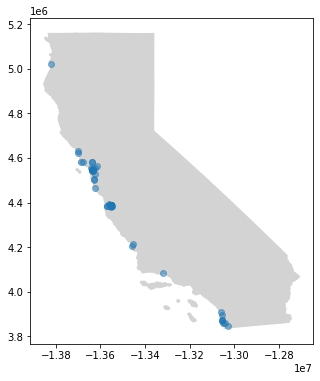

In [14]:
# ---- plot observations over california ----
ca_shape_path = "/home/jovyan/msai4earth-esa/shapefiles_n_rasters/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)

fig, ax = plt.subplots(figsize = (6,6))
ca_shape.plot(ax=ax, color='lightgrey')
obs[['geometry']].to_crs(ca_shape.crs).plot(ax=ax, alpha=0.5)

## USE POINTS TO EXTRACT BANDS INFO FROM NAIP IMAGE

To extract information about the NAIP image we will use the dataset method `sample()` from `ds`, which is a `rasterio.io.DatasetReader`. This method will return an iterable object, remember this can omly be iterated through once.

See more at:
https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html

Because not all coordinates will be within the NAIP image, some of the samples will be [0,0,0,0]. We need to discard those.

In [15]:
# Match observation crs with NAIP crs
obs = obs[['geometry']]
obs['geometry'] = obs['geometry'].to_crs(ds.crs)

# we will need this form for the coordiantes to extract bands
#obs['xy'] = obs.geometry.apply(lambda p: (p.x,p.y))
#obs.head()

In [29]:
fp = os.getcwd() +'/observations-220884.csv'
obs = gpd.GeoDataFrame(
    pd.read_csv(fp), 
    crs = "EPSG:4326",
    geometry = gpd.points_from_xy(
        x= pd.read_csv(fp).longitude, 
        y= pd.read_csv(fp).latitude)
)
obs['geometry'] = obs['geometry'].to_crs(ds.crs)

In [42]:
# Find points within NAIP image

naip_box = shapely.geometry.box(*ds.bounds)
df = []
for point in obs['geometry']:
    if naip_box.contains(point):
        df.append(point)

naip_obs = gpd.GeoDataFrame()
naip_obs['geometry']=df
naip_obs.set_crs(ds.crs, inplace=True)
naip_obs.to_file(os.getcwd()+'/naip16_obs.shp')


/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Opening polygons extracted from QGIS

In [10]:
fp = os.getcwd() + '/polygons_2016/trial.shp'
trial = gpd.read_file(fp)
trial

,id,geometry
0,0,"POLYGON ((-119.84689 34.40631, -119.84356 34.4..."
1,1,"POLYGON ((-119.84710 34.41094, -119.84223 34.4..."
2,2,"POLYGON ((-119.86752 34.41834, -119.85331 34.4..."


In [5]:
print(trial['geometry'][0])

POLYGON ((-119.8468887552101 34.40631400745776, -119.84356200866763 34.40633579107665, -119.84419567467569 34.404854492070015, -119.8468887552101 34.40631400745776))


In [20]:
trial.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

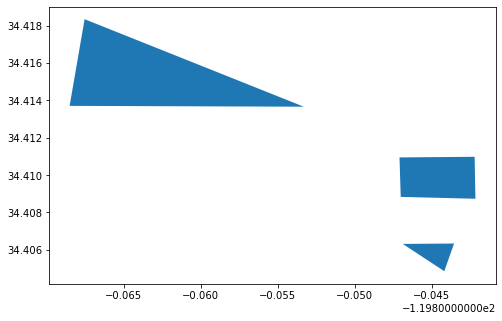

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
trial.plot(ax=ax)

In [31]:
#from shapely.geometry import Point
import random

######
def random_points_in_polygon(number, polygon):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points  
######

<AxesSubplot:>

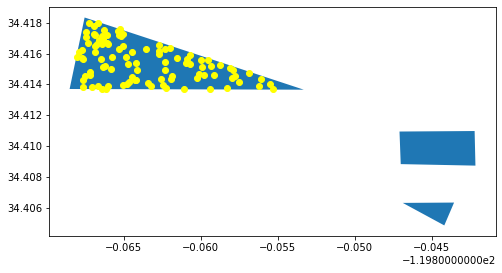

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
trial.plot(ax=ax)
geo_points.plot(ax=ax, color="yellow")

In [35]:
i=2
points = random_points_in_polygon(100,trial['geometry'][i])
geo_points = gpd.GeoDataFrame()
geo_points['geometry']=points
geo_points

,geometry
0,POINT (-119.84389 34.40598)
1,POINT (-119.84591 34.40611)
2,POINT (-119.84434 34.40631)
3,POINT (-119.84478 34.40609)
4,POINT (-119.84456 34.40594)
5,POINT (-119.84441 34.40619)
6,POINT (-119.84457 34.40632)
7,POINT (-119.84464 34.40590)
8,POINT (-119.84556 34.40596)
9,POINT (-119.84665 34.40625)


## Sample NAIP image data at observation coords

In [46]:
sample = ds.sample(coords.xy)

data = []
for i in sample:
    if (i!= [0,0,0,0]).all():
        data.append(i)
data = np.vstack(data)
data = pd.DataFrame(data, columns=['r','g','b','nifr'])
data

,r,g,b,nifr
0,40,50,65,59
1,82,86,89,141
2,172,166,154,168
3,127,121,119,135
4,102,97,96,137
5,178,176,164,162
6,156,159,138,185
7,83,79,81,127
